# RITAL - Bag of Words Project

Binôme :
- **Ben KABONGO**, 21116436

- **Sofia BORCHANI**, 21212080

# Partie II : Données classification de sentiments (films)

Dans cette section, nous étudions les temps d'exécutions et les performances des différents modèles.

**Problématiques :**
- Combien de temps ça prend d'apprendre un classifieur NB/SVM/RegLog sur ces données en fonction de la taille du vocabulaire?
- La validation croisée est-elle nécessaire? Est ce qu'on obtient les mêmes résultats avec un simple *split*?
- La validation croisée est-elle stable? A partir de combien de fold (travailler avec différentes graines aléatoires et faire des statistiques basiques)?

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import utils
import warnings
import time

from imblearn.under_sampling import RandomUnderSampler
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn import (linear_model, 
                     ensemble,
                     tree,
                     decomposition, 
                     naive_bayes, 
                     svm,
                     metrics,
                     preprocessing, 
                     model_selection, 
                     pipeline,)
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [2]:
plt.style.use('seaborn-whitegrid')
warnings.simplefilter("ignore")

C:\Users\sofia\AppData\Local\Temp\ipykernel_31960\2498793555.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


### Chargement des données

In [3]:
fname = "./datasets/movies/movies1000/"
all_movies_df = utils.load_movies(fname)
all_movies_df

,text,label
0,"plot : two teen couples go to a church party ,...",0
1,the happy bastard's quick movie review \ndamn ...,0
2,it is movies like these that make a jaded movi...,0
3,""" quest for camelot "" is warner bros . ' firs...",0
4,synopsis : a mentally unstable man undergoing ...,0
...,...,...
1995,wow ! what a movie . \nit's everything a movie...,1
1996,"richard gere can be a commanding actor , but h...",1
1997,"glory--starring matthew broderick , denzel was...",1
1998,steven spielberg's second epic film on world w...,1


In [4]:
y = all_movies_df.label

### Evaluations du temps d'apprentissage

In [5]:
# taille du vocabulaire
sizes = [10, 100, 1000, 10_000, 20_000, 40_000, 50_000, 80_000, 100_000]

In [6]:
# fonction de preprocessing : suppression de balise, mots maj, chiffres, ponctuation
f = lambda doc: utils.delete_balise( utils.replace_maj_word( utils.delete_digit( utils.delete_punctuation(doc) ) ) )

In [7]:
datasets = {}

for s in sizes:
    cv = CountVectorizer(preprocessor=f, ngram_range=(1, 3), stop_words=stopwords.words('french'), 
                     tokenizer=word_tokenize, lowercase=True, max_features=s)

    X = cv.fit_transform(all_movies_df.text)

    X_train, X_test, y_train, y_test = model_selection.train_test_split(
        X, y, test_size=0.2, random_state=0)
    
    rus = RandomUnderSampler(random_state=42)
    X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

    datasets[s] = [X_resampled, X_test, y_resampled, y_test]

#### Regression logistique

In [8]:
times_rl = []
accuracy_rl = []
f1_score_rl = []
balanced_accuracy_rl = []

print('----------------------- Logistic Regression -----------------------')

for s in sizes:
    X_train, X_test, y_train, y_test = datasets[s]

    clf = linear_model.LogisticRegression()
    t = time.time()
    clf.fit(X_train, y_train)
    t = (time.time() - t) * 1000

    y_pred = clf.predict(X_test)

    acc = metrics.accuracy_score(y_pred, y_test)
    f1 = metrics.f1_score(y_pred, y_test)
    balanced_acc = metrics.balanced_accuracy_score(y_pred, y_test)

    times_rl.append(t)
    accuracy_rl.append(acc)
    f1_score_rl.append(f1)
    balanced_accuracy_rl.append(balanced_acc)

    print('\tVocabulary Size \t:', s)
    print('\tLearning Time \t\t:', t)
    print('\tAccuracy \t\t:', acc)
    print('\tF1 Score \t\t:', f1)
    print('\tBalanced accuracy \t:', balanced_acc)
    print('-------------------------------------------------------------------')

----------------------- Logistic Regression -----------------------
	Vocabulary Size 	: 10
	Learning Time 		: 65.85884094238281
	Accuracy 		: 0.6425
	F1 Score 		: 0.6323907455012853
	Balanced accuracy 	: 0.6429323704205221
-------------------------------------------------------------------
	Vocabulary Size 	: 100
	Learning Time 		: 116.89925193786621
	Accuracy 		: 0.73
	F1 Score 		: 0.728643216080402
	Balanced accuracy 	: 0.7300230023002301
-------------------------------------------------------------------
	Vocabulary Size 	: 1000
	Learning Time 		: 289.2608642578125
	Accuracy 		: 0.79
	F1 Score 		: 0.7910447761194029
	Balanced accuracy 	: 0.7900290029002901
-------------------------------------------------------------------
	Vocabulary Size 	: 10000
	Learning Time 		: 784.6682071685791
	Accuracy 		: 0.85
	F1 Score 		: 0.8477157360406091
	Balanced accuracy 	: 0.8503152837553798
-------------------------------------------------------------------
	Vocabulary Size 	: 20000
	Learning Time

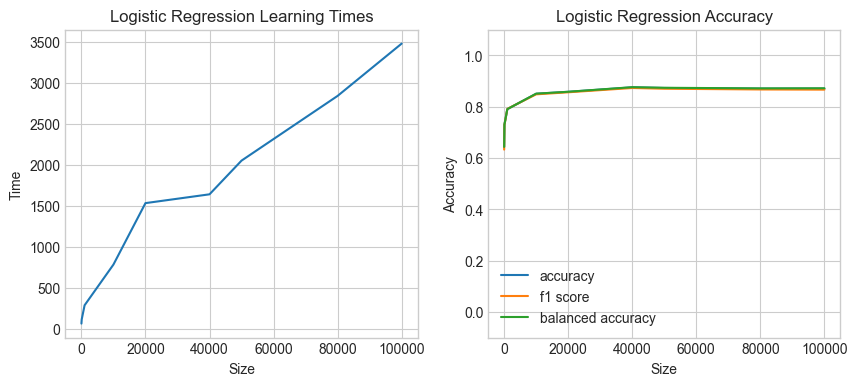

In [9]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
axes[0].set_title('Logistic Regression Learning Times')
axes[0].plot(sizes, times_rl)
axes[0].set_xlabel('Size')
axes[0].set_ylabel('Time')

axes[1].set_title('Logistic Regression Accuracy')
axes[1].plot(sizes, accuracy_rl, label='accuracy')
axes[1].plot(sizes, f1_score_rl, label='f1 score')
axes[1].plot(sizes, balanced_accuracy_rl, label='balanced accuracy')
axes[1].set_xlabel('Size')
axes[1].set_ylabel('Accuracy')
axes[1].set_ylim([-.1, 1.1])
axes[1].legend()

plt.show()

#### Naive Bayes

In [10]:
times_nv = []
accuracy_nv = []
f1_score_nv = []
balanced_accuracy_nv = []

print('--------------------------- Naive Bayes ----------------------------')

for s in sizes:
    X_train, X_test, y_train, y_test = datasets[s]

    clf = naive_bayes.MultinomialNB()
    t = time.time()
    clf.fit(X_train, y_train)
    t = (time.time() - t) * 1000

    y_pred = clf.predict(X_test)

    acc = metrics.accuracy_score(y_pred, y_test)
    f1 = metrics.f1_score(y_pred, y_test)
    balanced_acc = metrics.balanced_accuracy_score(y_pred, y_test)

    times_nv.append(t)
    accuracy_nv.append(acc)
    f1_score_nv.append(f1)
    balanced_accuracy_nv.append(balanced_acc)

    print('\tVocabulary Size \t:', s)
    print('\tLearning Time \t\t:', t)
    print('\tAccuracy \t\t:', acc)
    print('\tF1 Score \t\t:', f1)
    print('\tBalanced accuracy \t:', balanced_acc)
    print('-------------------------------------------------------------------')

--------------------------- Naive Bayes ----------------------------
	Vocabulary Size 	: 10
	Learning Time 		: 2.99072265625
	Accuracy 		: 0.64
	F1 Score 		: 0.64
	Balanced accuracy 	: 0.64
-------------------------------------------------------------------
	Vocabulary Size 	: 100
	Learning Time 		: 2.0532608032226562
	Accuracy 		: 0.67
	F1 Score 		: 0.6857142857142857
	Balanced accuracy 	: 0.6717171717171717
-------------------------------------------------------------------
	Vocabulary Size 	: 1000
	Learning Time 		: 3.9892196655273438
	Accuracy 		: 0.75
	F1 Score 		: 0.7584541062801932
	Balanced accuracy 	: 0.7512310320570796
-------------------------------------------------------------------
	Vocabulary Size 	: 10000
	Learning Time 		: 6.548166275024414
	Accuracy 		: 0.8475
	F1 Score 		: 0.8501228501228502
	Balanced accuracy 	: 0.8479262096067683
-------------------------------------------------------------------
	Vocabulary Size 	: 20000
	Learning Time 		: 8.975982666015625
	Accur

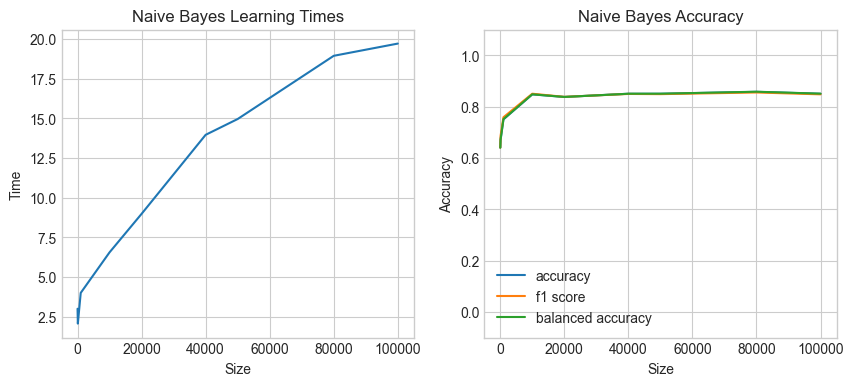

In [11]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
axes[0].set_title('Naive Bayes Learning Times')
axes[0].plot(sizes, times_nv)
axes[0].set_xlabel('Size')
axes[0].set_ylabel('Time')

axes[1].set_title('Naive Bayes Accuracy')
axes[1].plot(sizes, accuracy_nv, label='accuracy')
axes[1].plot(sizes, f1_score_nv, label='f1 score')
axes[1].plot(sizes, balanced_accuracy_nv, label='balanced accuracy')
axes[1].set_xlabel('Size')
axes[1].set_ylabel('Accuracy')
axes[1].set_ylim([-.1, 1.1])
axes[1].legend()

plt.show()

#### Regression logistique vs Naive Bayes

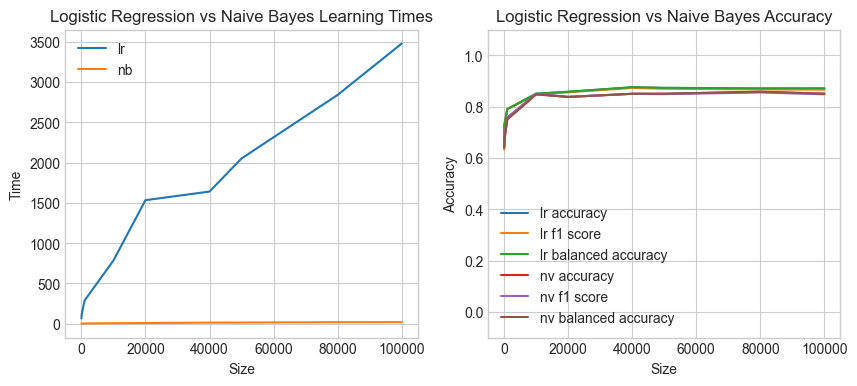

In [12]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
axes[0].set_title('Logistic Regression vs Naive Bayes Learning Times')
axes[0].plot(sizes, times_rl, label='lr')
axes[0].plot(sizes, times_nv, label='nb')
axes[0].set_xlabel('Size')
axes[0].set_ylabel('Time')
axes[0].legend()

axes[1].set_title('Logistic Regression vs Naive Bayes Accuracy')
axes[1].plot(sizes, accuracy_rl, label='lr accuracy')
axes[1].plot(sizes, f1_score_rl, label='lr f1 score')
axes[1].plot(sizes, balanced_accuracy_rl, label='lr balanced accuracy')
axes[1].plot(sizes, accuracy_nv, label='nv accuracy')
axes[1].plot(sizes, f1_score_nv, label='nv f1 score')
axes[1].plot(sizes, balanced_accuracy_nv, label='nv balanced accuracy')
axes[1].set_xlabel('Size')
axes[1].set_ylabel('Accuracy')
axes[1].set_ylim([-.1, 1.1])
axes[1].legend()

plt.show()

#### Support Vector

In [13]:
times_svm = []
accuracy_svm = []
f1_score_svm = []
balanced_accuracy_svm = []

print('--------------------------- Support Vector --------------------------')

for s in sizes:
    X_train, X_test, y_train, y_test = datasets[s]

    clf = svm.SVC()
    t = time.time()
    clf.fit(X_train, y_train)
    t = (time.time() - t) * 1000

    y_pred = clf.predict(X_test)

    acc = metrics.accuracy_score(y_pred, y_test)
    f1 = metrics.f1_score(y_pred, y_test)
    balanced_acc = metrics.balanced_accuracy_score(y_pred, y_test)

    times_svm.append(t)
    accuracy_svm.append(acc)
    f1_score_svm.append(f1)
    balanced_accuracy_svm.append(balanced_acc)

    print('\tVocabulary Size \t:', s)
    print('\tLearning Time \t\t:', t)
    print('\tAccuracy \t\t:', acc)
    print('\tF1 Score \t\t:', f1)
    print('\tBalanced accuracy \t:', balanced_acc)
    print('-------------------------------------------------------------------')

--------------------------- Support Vector --------------------------
	Vocabulary Size 	: 10
	Learning Time 		: 139.9681568145752
	Accuracy 		: 0.6675
	F1 Score 		: 0.6376021798365121
	Balanced accuracy 	: 0.6721878132147722
-------------------------------------------------------------------
	Vocabulary Size 	: 100
	Learning Time 		: 1603.1770706176758
	Accuracy 		: 0.7175
	F1 Score 		: 0.7002652519893899
	Balanced accuracy 	: 0.7204149882191989
-------------------------------------------------------------------
	Vocabulary Size 	: 1000
	Learning Time 		: 6753.018617630005
	Accuracy 		: 0.775
	F1 Score 		: 0.7580645161290323
	Balanced accuracy 	: 0.7804977560179518
-------------------------------------------------------------------
	Vocabulary Size 	: 10000
	Learning Time 		: 12327.687740325928
	Accuracy 		: 0.7925
	F1 Score 		: 0.7750677506775068
	Balanced accuracy 	: 0.7997002997002998
-------------------------------------------------------------------
	Vocabulary Size 	: 20000
	Lear

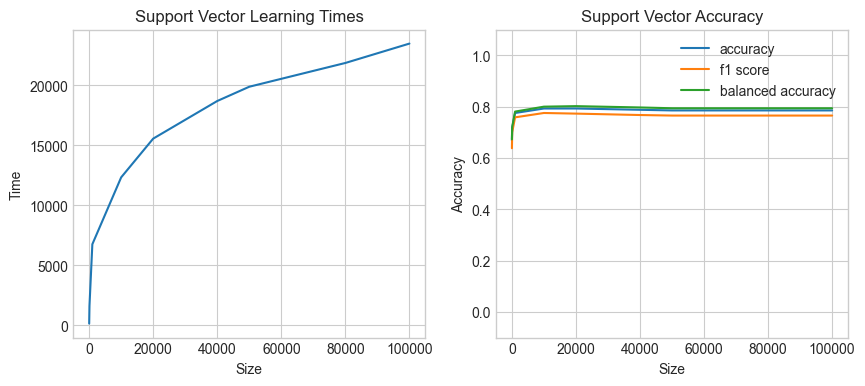

In [14]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
axes[0].set_title('Support Vector Learning Times')
axes[0].plot(sizes, times_svm)
axes[0].set_xlabel('Size')
axes[0].set_ylabel('Time')

axes[1].set_title('Support Vector Accuracy')
axes[1].plot(sizes, accuracy_svm, label='accuracy')
axes[1].plot(sizes, f1_score_svm, label='f1 score')
axes[1].plot(sizes, balanced_accuracy_svm, label='balanced accuracy')
axes[1].set_xlabel('Size')
axes[1].set_ylabel('Accuracy')
axes[1].set_ylim([-.1, 1.1])
axes[1].legend()

plt.show()

#### Regression Logitique vs SVM

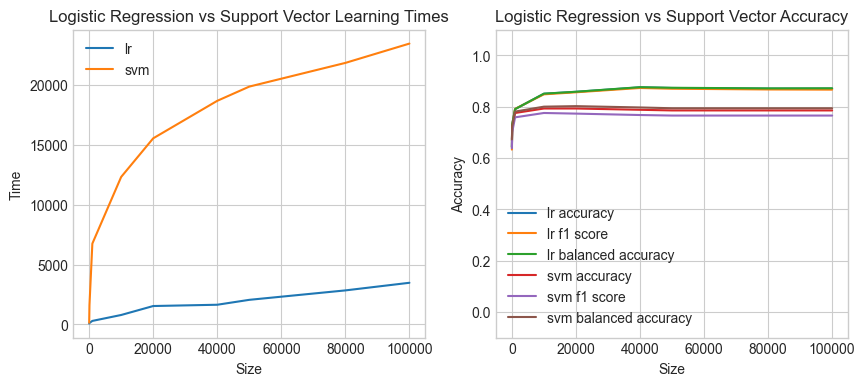

In [15]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
axes[0].set_title('Logistic Regression vs Support Vector Learning Times')
axes[0].plot(sizes, times_rl, label='lr')
axes[0].plot(sizes, times_svm, label='svm')
axes[0].set_xlabel('Size')
axes[0].set_ylabel('Time')
axes[0].legend()

axes[1].set_title('Logistic Regression vs Support Vector Accuracy')
axes[1].plot(sizes, accuracy_rl, label='lr accuracy')
axes[1].plot(sizes, f1_score_rl, label='lr f1 score')
axes[1].plot(sizes, balanced_accuracy_rl, label='lr balanced accuracy')
axes[1].plot(sizes, accuracy_svm, label='svm accuracy')
axes[1].plot(sizes, f1_score_svm, label='svm f1 score')
axes[1].plot(sizes, balanced_accuracy_svm, label='svm balanced accuracy')
axes[1].set_xlabel('Size')
axes[1].set_ylabel('Accuracy')
axes[1].set_ylim([-.1, 1.1])
axes[1].legend()

plt.show()

### Validation croisée / Train-test split

In [16]:
cv = CountVectorizer(preprocessor=f, ngram_range=(1, 2), stop_words=stopwords.words('french'), 
                     tokenizer=word_tokenize, lowercase=True, max_features=5_000)

X = cv.fit_transform(all_movies_df.text)
y = all_movies_df.label

rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X, y)

X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42)

lr = linear_model.LogisticRegression(random_state=42, solver='lbfgs')
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

print('Train/test :')
print('\tAccuracy:', metrics.accuracy_score(y_test, y_pred))
print('\tPrecision:', metrics.precision_score(y_test, y_pred))
print('\tRecall:', metrics.recall_score(y_test, y_pred))
print('\tf1-score:', metrics.f1_score(y_test, y_pred))

print('Validation croisée :')
print('\tAccuracy:', np.mean(model_selection.cross_val_score(lr, X_resampled, y_resampled, cv=5)))
print('\tPrecision:', np.mean(model_selection.cross_val_score(lr, X_resampled, y_resampled, cv=5, scoring='precision')))
print('\tRecall:', np.mean(model_selection.cross_val_score(lr, X_resampled, y_resampled, cv=5, scoring='recall')))
print('\tf1-score:', np.mean(model_selection.cross_val_score(lr, X_resampled, y_resampled, cv=5, scoring='f1')))

Train/test :
	Accuracy: 0.85
	Precision: 0.827906976744186
	Recall: 0.8855721393034826
	f1-score: 0.8557692307692307
Validation croisée :
	Accuracy: 0.8345
	Precision: 0.8443812498329031
	Recall: 0.82
	f1-score: 0.831695404113318


### Validation croisée : stabilité

In [17]:
cv = CountVectorizer(preprocessor=f, ngram_range=(1, 2), stop_words=stopwords.words('french'), 
                     tokenizer=word_tokenize, lowercase=True, max_features=5_000)

X = cv.fit_transform(all_movies_df.text)
y = all_movies_df.label

rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X, y)

num_folds = 10

acc_scores = []
prec_scores = []
rec_scores = []
f1_scores = []

for seed in range(10):
    skf = model_selection.StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=seed)
    
    clf = linear_model.LogisticRegression(random_state=seed)
    
    cv_results = model_selection.cross_validate(clf, X_resampled, y_resampled, cv=skf, 
                                scoring=['accuracy', 'precision', 'recall', 'f1'])
    
    acc_scores.append(np.mean(cv_results['test_accuracy']))
    prec_scores.append(np.mean(cv_results['test_precision']))
    rec_scores.append(np.mean(cv_results['test_recall']))
    f1_scores.append(np.mean(cv_results['test_f1']))

mean_acc = np.mean(acc_scores)
std_acc = np.std(acc_scores)
mean_prec = np.mean(prec_scores)
std_prec = np.std(prec_scores)
mean_rec = np.mean(rec_scores)
std_rec = np.std(rec_scores)
mean_f1 = np.mean(f1_scores)
std_f1 = np.std(f1_scores)

print(f'Mean accuracy: {mean_acc:.4f} +/- {std_acc:.4f}')
print(f'Mean precision: {mean_prec:.4f} +/- {std_prec:.4f}')
print(f'Mean recall: {mean_rec:.4f} +/- {std_rec:.4f}')
print(f'Mean F1-score: {mean_f1:.4f} +/- {std_f1:.4f}')

Mean accuracy: 0.8384 +/- 0.0054
Mean precision: 0.8444 +/- 0.0040
Mean recall: 0.8314 +/- 0.0083
Mean F1-score: 0.8373 +/- 0.0059


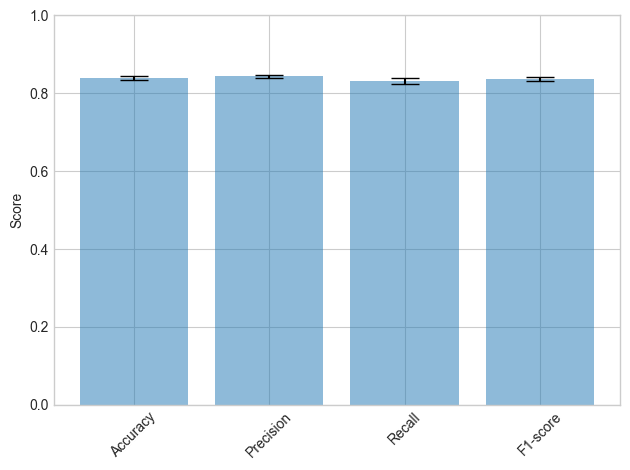

In [18]:
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score']
means = [mean_acc, mean_prec, mean_rec, mean_f1]
stds = [std_acc, std_prec, std_rec, std_f1]

fig, ax = plt.subplots()
ax.bar(metrics, means, yerr=stds, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('Score')
ax.set_ylim(0, 1)
ax.set_xticklabels(metrics, rotation=45)
ax.yaxis.grid(True)

plt.tight_layout()
plt.show()